# Make Beam for BeamFour

Generate that particular RAY file used by BeamFour.
The convergent beam is generated.
In this version inclined incident beam is implemented.

The output file is generated using implemented function based on python formatted string.

- author : Sylvie Dagoret-Campagne
- creation date : August 26th 2020
- update : August 27th 2020 : Add logging, coloredlogs, configparser


In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as plt3d
import numpy as np
import os
import matplotlib as mpl
import pandas as pd
import itertools

2020-08-28 17:19:28 MacBook-Pro-de-admin.local matplotlib.pyplot[51916] DEBUG Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [31]:
from astropy import units as u
from astropy.coordinates import Angle

In [32]:
import logging
import coloredlogs
import configparser

In [33]:
logging.basicConfig()
logging.root.setLevel(logging.NOTSET)
#logging.basicConfig(level=logging.NOTSET) # both commands above are equivalent

In [34]:
handle = __name__

In [35]:
logger = logging.getLogger(handle)
#logging.getLogger().setLevel(logging.INFO)
logger.setLevel(logging.WARNING)

In [36]:
# If you don't want to see log messages from libraries, you can pass a
# specific logger object to the install() function. In this case only log
# messages originating from that logger will show up on the terminal.
coloredlogs.install(level='DEBUG', logger=logger)

In [37]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (8, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

# configuration 

In [38]:
logger.info('Configuration')

In [39]:
config = configparser.ConfigParser()

In [40]:
config_filename="conf_AuxTel_2020_08_27.ini"

In [41]:
if os.path.exists(config_filename):
    config.read(config_filename)
else:
    msg =f"config file {config_filename} does not exist !"
    logger.error(msg)
    

In [42]:
config_section = config.sections()

if len(config_section) == 0 :
    msg =f"empty config file {config_filename} !"
    logger.error(msg)

In [43]:
if 'BEAMFOUR' in config_section:
    output_dir    = config['BEAMFOUR']['outputdir']     # output directory
    root_filename = config['BEAMFOUR']['outputrayfile'] # base ray filename
    theta_x       = float(config['BEAMFOUR']['Theta_X']) # target offset in arcmin
    theta_y       = float(config['BEAMFOUR']['Theta_Y']) # target offset in arcmin
    NBEAM_X       = int(config['BEAMFOUR']['NBEAM_X'])  # nb of rays should be odd number
    NBEAM_Y       = int(config['BEAMFOUR']['NBEAM_Y'])  # nb of rays should be odd number
    WLMIN         = float(config['BEAMFOUR']['WLMIN'])   # minimum of wavelength in nm
    WLMAX         = float(config['BEAMFOUR']['WLMAX'])   # maximum of wavelength in nm
    WLSTEP        = float(config['BEAMFOUR']['WLSTEP'])  # wavelength step in nm
else:
    msg =f"empty section BEAMFOUR in config file {config_filename} !"
    logger.error(msg)

In [44]:
output_dir

'output'

In [45]:
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [46]:
root_filename 

'Beam4_Rayfile_'

In [47]:
# number of rays
NBEAM=NBEAM_X*NBEAM_Y

In [48]:
Wavelength=np.arange(WLMIN,WLMAX,WLSTEP)
WL=(Wavelength).astype(int)
NWL=len(WL)

In [49]:
WL

array([ 350,  375,  400,  425,  450,  475,  500,  525,  550,  575,  600,
        625,  650,  675,  700,  725,  750,  775,  800,  825,  850,  875,
        900,  925,  950,  975, 1000, 1025, 1050, 1075, 1100])

In [50]:
theta_x_num=int(theta_x*100)
theta_y_num=int(theta_y*100)

In [51]:
if theta_x_num>=0:
    theta_nstr='{:0>2}'.format(theta_x_num)
    theta_nstr=theta_nstr.zfill(4)
    theta_x_str="p"+theta_nstr
else:
    theta_nstr='{:0>2}'.format(-theta_x_num)
    theta_nstr=theta_nstr.zfill(4)
    theta_x_str="m"+theta_nstr

In [52]:
if theta_y_num>=0:
    theta_nstr='{:0>2}'.format(theta_y_num)
    theta_nstr=theta_nstr.zfill(4)
    theta_y_str="p"+theta_nstr
else:
    theta_nstr='{:0>2}'.format(-theta_y_num)
    theta_nstr=theta_nstr.zfill(4)
    theta_y_str="m"+theta_nstr

In [53]:
Beam4_Rayfile_EXCEL=root_filename+"{:d}_nw{:d}_thx{}_thy{}.xlsx".format(NBEAM,NWL,theta_x_str,theta_y_str)
Beam4_Rayfile_RAY=root_filename+"{:d}_nw{:d}_thx{}_thy{}.RAY".format(NBEAM,NWL,theta_x_str,theta_y_str)

In [54]:
Beam4_Rayfile_EXCEL

'Beam4_Rayfile_121_nw31_thxp1000_thyp0000.xlsx'

In [55]:
Beam4_Rayfile_RAY

'Beam4_Rayfile_121_nw31_thxp1000_thyp0000.RAY'

## Configuration of Telescope

In [56]:
if 'TELESCOPE' in config_section:
    Tel_Focal_Length = float(config['TELESCOPE']['Tel_Focal_Length']) 
    Tel_Diameter= float(config['TELESCOPE']['Tel_Diameter'])
else:
    msg =f"empty section TELESCOPE in config file {config_filename} !"
    logger.error(msg)

In [57]:
#Tel_Focal_Length=21.6# m : Focal length of the telescope
#Tel_Diameter=1.2# m : Diameter of the telescope  

In [58]:
Tel_Fnum=Tel_Focal_Length/Tel_Diameter

In [59]:
print("Aperture/D =  {} ".format(Tel_Fnum))

Aperture/D =  18.000000000000004 


## distance between the entrance plane and the focal plane

In [60]:
if 'OPTICS' in config_section:   
    D_entrance = float(config['OPTICS']['D_entrance']) # mm : distance focal plane - entrance
    D_disperser = float(config['OPTICS']['D_disperser'])# mm : distance focal plane - disperser
else:
    msg =f"empty section OPTICS in config file {config_filename} !"
    logger.error(msg)

In [61]:
D_entrance

-220.0

In [62]:
D_disperser

-200.0

In [63]:
d=-D_entrance  # here set to be in mm (the BeamFour length units)

# Functions

In [64]:
def set_aspect_equal_3d(ax):
    """Fix equal aspect bug for 3D plots."""

    xlim = ax.get_xlim3d()
    ylim = ax.get_ylim3d()
    zlim = ax.get_zlim3d()

    from numpy import mean
    xmean = mean(xlim)
    ymean = mean(ylim)
    zmean = mean(zlim)

    plot_radius = max([abs(lim - mean_)
                       for lims, mean_ in ((xlim, xmean),
                                           (ylim, ymean),
                                           (zlim, zmean))
                       for lim in lims])

    ax.set_xlim3d([xmean - plot_radius, xmean + plot_radius])
    ax.set_ylim3d([ymean - plot_radius, ymean + plot_radius])
    ax.set_zlim3d([zmean - plot_radius, zmean + plot_radius])

In [65]:
def EntranceBeamPopulation(nbeamx,nbeamy,f,D,d):
    """
    EntranceBeamPopulation(nbeamx,nbeamy,thetax,thetay,f,D,d)
    
    input arguments :
      - nbeamx : number of beam along x (should be odd, by example 11)
      - nbeamy : number of beam along y (should be odd, by example 11)
      - thetax : central beam angle along x in radian 
      - f : telescope focal length in m
      - D : telescope diameter in m
      - d : distance entrance (beam start) to focal plane. the unit of d is what we want
      
      
    output arguments :
      - return X,Y coordinate of beams relative to central beam (position (0,0)) in same unit as d
    """
    
    numberOfRows = nbeamx*nbeamy
    
    X=np.linspace(-D*d/2/f,D*d/2/f,nbeamx)
    Y=np.linspace(-D*d/2/f,D*d/2/f,nbeamy)
    
    # need to alloc memory for the dataframe
    df=pd.DataFrame(index=np.arange(0, numberOfRows),columns=['id','nx', 'ny', 'X0','Y0'])
    
    idx=0
    for ny in np.arange(len(Y)):
        for nx in np.arange(len(X)):         
            df.iloc[idx]= [idx+1, nx,ny,X[nx],Y[ny]]
            idx+=1
            
    df["Z0"] = -d
    
    return df
    

In [66]:
def ComputeAngles(df_in,alphax,alphay,d):
    """
    ComputeAngles(df_in,thetax,thetay,d)
    
    * input argument :
      - df_in :  input data frame (beam centered at beam entrance)
      - alphax,alphay :  angles in radians of central ray relative to optical beam 
      - d : distance entrance -focal point in mm
      
    * output argument
      -df : modified dataframe
    
    
    """
    tan_alphax_0=np.tan(alphax)
    tan_alphay_0=np.tan(alphay)
    x=np.asarray(df_in["X0"].values).astype(np.float64)
    y=np.asarray(df_in["Y0"].values).astype(np.float64)
    
    tan_alphax=np.array(tan_alphax_0-x/d)
    tan_alphay=np.array(tan_alphay_0-y/d)
    
    
    Uz=1./(np.sqrt(1.+tan_alphax**2+tan_alphay**2))
    Ux=tan_alphax*Uz
    Uy=tan_alphay*Uz
    
    df=df_in
    df["U0"]=Ux
    df["V0"]=Uy
    df["W0"]=Uz
    
    return df   

In [67]:
def ShiftBeamCenter(df_in,alphax,alphay,D_in,D_disp):
    """
    ShiftBeamCenter(df_in,thetax,thetay,f,D_in,D_disp): shift the beam such
    the central ray beam is at center of disperser
    
   
    * input arguments:
      - df_in : input data frame (beam centered at beam entrance)
      - alphax,alphay :  angles in radians of central ray relative to optical beam 
      - d : distance entrance -focal point in mm
      
    * output argument:
      -df : modified dataframe
    
    """
    
    # shift in X,Y
    # alphax < 0 : move up
    # alphax > 0 : move down
    dx=np.tan(alphax)*np.abs(D_disp-D_in)
    dy=np.tan(alphay)*np.abs(D_disp-D_in)
    df_out=df_in
    
    df_out["X0"] = df_in.apply(lambda x: x.X0-dx , axis=1)
    df_out["Y0"] = df_in.apply(lambda x: x.Y0-dy , axis=1)
    
    return df_out
    

# Compute the beam Rays location and orientation

## repartition of beams at entrance

In [68]:
df=EntranceBeamPopulation(NBEAM_X,NBEAM_Y,Tel_Focal_Length,Tel_Diameter,-D_entrance)

In [69]:
df

,id,nx,ny,X0,Y0,Z0
0,1,0,0,-6.11111,-6.11111,-220.0
1,2,1,0,-4.88889,-6.11111,-220.0
2,3,2,0,-3.66667,-6.11111,-220.0
3,4,3,0,-2.44444,-6.11111,-220.0
4,5,4,0,-1.22222,-6.11111,-220.0
...,...,...,...,...,...,...
116,117,6,10,1.22222,6.11111,-220.0
117,118,7,10,2.44444,6.11111,-220.0
118,119,8,10,3.66667,6.11111,-220.0
119,120,9,10,4.88889,6.11111,-220.0


## Orientation of beams

In [70]:
alpha_x=-Angle(theta_x,unit=u.arcmin)
alpha_y=-Angle(theta_y,unit=u.arcmin)

In [71]:
df=ComputeAngles(df,alpha_x.radian,alpha_y.radian,d)

In [72]:
df

,id,nx,ny,X0,Y0,Z0,U0,V0,W0
0,1,0,0,-6.11111,-6.11111,-220.0,0.024852,0.027758,0.999306
1,2,1,0,-4.88889,-6.11111,-220.0,0.019302,0.027762,0.999428
2,3,2,0,-3.66667,-6.11111,-220.0,0.013751,0.027764,0.999520
3,4,3,0,-2.44444,-6.11111,-220.0,0.008199,0.027766,0.999581
4,5,4,0,-1.22222,-6.11111,-220.0,0.002646,0.027767,0.999611
...,...,...,...,...,...,...,...,...,...
116,117,6,10,1.22222,6.11111,-220.0,-0.008461,-0.027766,0.999579
117,118,7,10,2.44444,6.11111,-220.0,-0.014013,-0.027764,0.999516
118,119,8,10,3.66667,6.11111,-220.0,-0.019564,-0.027762,0.999423
119,120,9,10,4.88889,6.11111,-220.0,-0.025113,-0.027758,0.999299


### check the calculation of directions 

In [73]:
# compute the norm
df.apply(lambda x: np.sqrt(x.U0**2+x.V0**2+x.W0**2), axis=1)

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
116    1.0
117    1.0
118    1.0
119    1.0
120    1.0
Length: 121, dtype: float64

## Shift beam to have center ray at hologram center

In [74]:
alpha_x.decompose()

<Angle -0.00290888 rad>

In [75]:
df=ShiftBeamCenter(df,alpha_x.radian,alpha_y.radian,D_entrance,D_disperser)

### beams at entrance

2020-08-28 17:19:28 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=14.399999999999999.
2020-08-28 17:19:28 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal regular normal>) = 10.05
2020-08-28 17:19:28 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.ttf) normal normal regular normal>) = 10.05
2020-08-28 17:19:28 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal regular normal>) = 10.05
2020-08-28 17:19:28 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal 700 normal>) = 1.335
2020-08-28 17:19:28 MacBook-Pro-de-admin.local matplotlib.font_ma

2020-08-28 17:19:28 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'Noto Sans Thaana' (NotoSansThaana-Regular.ttf) normal normal regular normal>) = 10.05
2020-08-28 17:19:28 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'Devanagari MT' (DevanagariMT.ttc) normal normal 400 normal>) = 10.05
2020-08-28 17:19:28 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'Noteworthy' (Noteworthy.ttc) normal normal light normal>) = 10.24
2020-08-28 17:19:28 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'STIXIntegralsUpD' (STIXIntUpDBol.otf) normal normal 700 normal>) = 10.335
2020-08-28 17:19:28 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'Bangla Sangam MN' (Bangla Sangam MN.ttc) normal normal 400 normal>) = 10.05
2020-08-28 17:19:28 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: 

2020-08-28 17:19:28 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font '.Keyboard' (Keyboard.ttf) normal normal 400 normal>) = 10.05
2020-08-28 17:19:28 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'Noto Sans Cuneiform' (NotoSansCuneiform-Regular.ttf) normal normal regular normal>) = 10.05
2020-08-28 17:19:28 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'Arial Hebrew' (ArialHB.ttc) normal normal 400 normal>) = 10.05
2020-08-28 17:19:28 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'Noto Sans Old Turkic' (NotoSansOldTurkic-Regular.ttf) normal normal regular normal>) = 10.05
2020-08-28 17:19:28 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.otf) normal normal 700 normal>) = 10.335
2020-08-28 17:19:28 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEB

2020-08-28 17:19:28 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'Batang' (Batang.ttf) normal normal 400 normal>) = 10.05
2020-08-28 17:19:28 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'STIXIntegralsSm' (STIXIntSmReg.otf) normal normal regular normal>) = 10.05
2020-08-28 17:19:28 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'Arial Narrow' (Arial Narrow Italic.ttf) italic normal 400 condensed>) = 11.25
2020-08-28 17:19:28 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.otf) italic normal 400 normal>) = 11.05
2020-08-28 17:19:28 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'Microsoft Yi Baiti' (msyi.ttf) normal normal 400 normal>) = 10.05
2020-08-28 17:19:28 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font '.SF NS Text 

2020-08-28 17:19:28 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font '.SF NS Rounded' (SFNSRounded.ttf) normal normal 400 normal>) = 10.05
2020-08-28 17:19:28 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'Helvetica' (Helvetica.ttc) normal normal 400 normal>) = 7.322727272727273
2020-08-28 17:19:28 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'Noto Sans Mandaic' (NotoSansMandaic-Regular.ttf) normal normal regular normal>) = 10.05
2020-08-28 17:19:28 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'Noto Sans Buginese' (NotoSansBuginese-Regular.ttf) normal normal regular normal>) = 10.05
2020-08-28 17:19:28 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'Kailasa' (Kailasa.ttc) normal normal regular normal>) = 10.05
2020-08-28 17:19:28 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBU

2020-08-28 17:19:28 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'Gulim' (Gulim.ttf) normal normal 400 normal>) = 10.05
2020-08-28 17:19:28 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'MS PGothic' (MS PGothic.ttf) normal normal 400 normal>) = 10.05
2020-08-28 17:19:28 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'Oriya MN' (Oriya MN.ttc) normal normal 400 normal>) = 10.05
2020-08-28 17:19:28 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'Skia' (Skia.ttf) normal normal 400 normal>) = 10.05
2020-08-28 17:19:28 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'Gujarati Sangam MN' (Gujarati Sangam MN.ttc) normal normal 400 normal>) = 10.05
2020-08-28 17:19:28 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'Hoefler Text' (Hoefler Text.ttc) normal normal 4

2020-08-28 17:19:29 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'Noto Sans Imperial Aramaic' (NotoSansImperialAramaic-Regular.ttf) normal normal regular normal>) = 10.05
2020-08-28 17:19:29 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'Noto Sans Old Persian' (NotoSansOldPersian-Regular.ttf) normal normal regular normal>) = 10.05
2020-08-28 17:19:29 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font '.SF Compact Rounded' (SFCompactRounded.ttf) normal normal 400 normal>) = 10.05
2020-08-28 17:19:29 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBolIta.otf) italic normal 700 normal>) = 11.335
2020-08-28 17:19:29 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'Arial' (Arial Italic.ttf) italic normal 400 normal>) = 7.413636363636363
2020-08-28 17:19:29 MacBook-Pro-de-adm

2020-08-28 17:19:29 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'Calibri' (Calibril.ttf) normal normal light normal>) = 10.24
2020-08-28 17:19:29 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'Comic Sans MS' (Comic Sans MS Bold.ttf) normal normal 700 normal>) = 10.335
2020-08-28 17:19:29 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'Lucida Grande' (LucidaGrande.ttc) normal normal 400 normal>) = 2.777272727272727
2020-08-28 17:19:29 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'Noto Sans Tai Tham' (NotoSansTaiTham-Regular.ttf) normal normal 400 normal>) = 10.05
2020-08-28 17:19:29 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'Courier New' (Courier New Bold.ttf) normal normal 700 normal>) = 10.335
2020-08-28 17:19:29 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfo

2020-08-28 17:19:29 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'Malayalam Sangam MN' (Malayalam Sangam MN.ttc) normal normal 400 normal>) = 10.05
2020-08-28 17:19:29 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Ultralight.otf) normal normal ultralight condensed>) = 10.535
2020-08-28 17:19:29 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.otf) normal normal 700 normal>) = 10.335
2020-08-28 17:19:29 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'MingLiU-ExtB' (MingLiU-ExtB.ttf) normal normal 400 normal>) = 10.05
2020-08-28 17:19:29 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'Perpetua' (Perpetua Bold.ttf) normal normal 700 normal>) = 10.335
2020-08-28 17:19:29 MacBook-Pro-de-admin.local matplotlib.fo

2020-08-28 17:19:29 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'Noto Sans Phoenician' (NotoSansPhoenician-Regular.ttf) normal normal regular normal>) = 10.05
2020-08-28 17:19:29 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'MingLiU_HKSCS' (mingliu_hkscs.ttf) normal normal 400 normal>) = 10.05
2020-08-28 17:19:29 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'Times New Roman' (Times New Roman Bold Italic.ttf) italic normal 700 normal>) = 11.335
2020-08-28 17:19:29 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'Noto Sans Osmanya' (NotoSansOsmanya-Regular.ttf) normal normal regular normal>) = 10.05
2020-08-28 17:19:29 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'Futura' (Futura.ttc) normal normal medium normal>) = 10.145
2020-08-28 17:19:29 MacBook-Pro-de-admin.local matplotlib.font_man

2020-08-28 17:19:29 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=14.399999999999999 to DejaVu Sans ('/Users/dagoret/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.


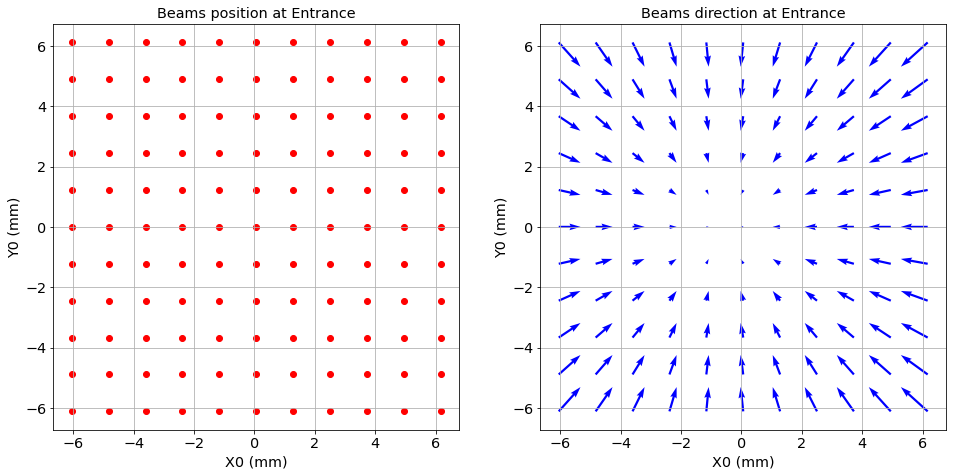

In [76]:
fig=plt.figure(figsize=(16,8))

ax=fig.add_subplot(121)
ax.scatter(df["X0"].values,df["Y0"].values,color="r")
ax.grid()
ax.set_xlabel("X0 (mm)")
ax.set_ylabel("Y0 (mm)")
ax.set_title("Beams position at Entrance")
ax.set_aspect('equal')


ax=fig.add_subplot(122)
X=np.asarray(df["X0"].values).astype(np.float64)
Y=np.asarray(df["Y0"].values).astype(np.float64)
U=np.asarray(df["U0"].values).astype(np.float64)
V=np.asarray(df["V0"].values).astype(np.float64)

ax.quiver(X,Y,U,V,color="b")
ax.grid()
ax.set_xlabel("X0 (mm)")
ax.set_ylabel("Y0 (mm)")
ax.set_title("Beams direction at Entrance")
ax.set_aspect('equal')


## Compute focal point position ad Z=d

In [77]:
df["X1"]=df.apply(lambda x: (x.X0+d*x.U0/x.W0), axis=1)
df["Y1"]=df.apply(lambda x: (x.Y0+d*x.V0/x.W0), axis=1)
df["Z1"] = 0

In [94]:
D_entrance

-220.0

In [78]:
df

,id,nx,ny,X0,Y0,Z0,U0,V0,W0,X1,Y1,Z1
0,1,0,0,-6.052933,-6.111111,-220.0,0.024852,0.027758,0.999306,-0.581778,8.881784e-16,0
1,2,1,0,-4.830711,-6.111111,-220.0,0.019302,0.027762,0.999428,-0.581778,0.000000e+00,0
2,3,2,0,-3.608489,-6.111111,-220.0,0.013751,0.027764,0.999520,-0.581778,0.000000e+00,0
3,4,3,0,-2.386267,-6.111111,-220.0,0.008199,0.027766,0.999581,-0.581778,0.000000e+00,0
4,5,4,0,-1.164044,-6.111111,-220.0,0.002646,0.027767,0.999611,-0.581778,0.000000e+00,0
...,...,...,...,...,...,...,...,...,...,...,...,...
116,117,6,10,1.280400,6.111111,-220.0,-0.008461,-0.027766,0.999579,-0.581778,0.000000e+00,0
117,118,7,10,2.502622,6.111111,-220.0,-0.014013,-0.027764,0.999516,-0.581778,0.000000e+00,0
118,119,8,10,3.724844,6.111111,-220.0,-0.019564,-0.027762,0.999423,-0.581778,0.000000e+00,0
119,120,9,10,4.947067,6.111111,-220.0,-0.025113,-0.027758,0.999299,-0.581778,0.000000e+00,0



# Plot 3D

In [79]:
X0=np.asarray(df["X0"].values).astype(np.float64)
Y0=np.asarray(df["Y0"].values).astype(np.float64)
Z0=np.asarray(df["Z0"].values).astype(np.float64)

In [80]:
U0=np.asarray(df["U0"].values).astype(np.float64)
V0=np.asarray(df["V0"].values).astype(np.float64)
W0=np.asarray(df["W0"].values).astype(np.float64)

In [81]:
X1=np.asarray(df["X1"].values).astype(np.float64)
Y1=np.asarray(df["Y1"].values).astype(np.float64)
Z1=np.asarray(df["Z1"].values).astype(np.float64)

In [82]:
N=len(df)

In [83]:
all_X=np.concatenate((X0,X1))
all_Y=np.concatenate((Y0,Y1))
all_Z=np.concatenate((Z0,Z1))

2020-08-28 17:19:29 MacBook-Pro-de-admin.local matplotlib.axes._base[51916] DEBUG not adjusting title pos because a title was already placed manually: 0.920000
2020-08-28 17:19:29 MacBook-Pro-de-admin.local matplotlib.axes._base[51916] DEBUG title position was updated manually, not adjusting
2020-08-28 17:19:29 MacBook-Pro-de-admin.local matplotlib.axes._base[51916] DEBUG not adjusting title pos because a title was already placed manually: 0.920000
2020-08-28 17:19:29 MacBook-Pro-de-admin.local matplotlib.axes._base[51916] DEBUG title position was updated manually, not adjusting


Text(0.5, 1.05, 'Squared beam')

2020-08-28 17:19:30 MacBook-Pro-de-admin.local matplotlib.axes._base[51916] DEBUG title position was updated manually, not adjusting
2020-08-28 17:19:30 MacBook-Pro-de-admin.local matplotlib.axes._base[51916] DEBUG title position was updated manually, not adjusting
2020-08-28 17:19:30 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=25.0.
2020-08-28 17:19:30 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal regular normal>) = 10.05
2020-08-28 17:19:30 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.ttf) normal normal regular normal>) = 10.05
2020-08-28 17:19:30 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal regular normal>) = 10.0

2020-08-28 17:19:30 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'Apple SD Gothic Neo' (AppleSDGothicNeo.ttc) normal normal regular normal>) = 10.05
2020-08-28 17:19:30 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'Noto Sans Thaana' (NotoSansThaana-Regular.ttf) normal normal regular normal>) = 10.05
2020-08-28 17:19:30 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'Devanagari MT' (DevanagariMT.ttc) normal normal 400 normal>) = 10.05
2020-08-28 17:19:30 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'Noteworthy' (Noteworthy.ttc) normal normal light normal>) = 10.24
2020-08-28 17:19:30 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'STIXIntegralsUpD' (STIXIntUpDBol.otf) normal normal 700 normal>) = 10.335
2020-08-28 17:19:30 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG fin

2020-08-28 17:19:30 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'Kefa' (Kefa.ttc) normal normal regular normal>) = 10.05
2020-08-28 17:19:30 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font '.Keyboard' (Keyboard.ttf) normal normal 400 normal>) = 10.05
2020-08-28 17:19:30 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'Noto Sans Cuneiform' (NotoSansCuneiform-Regular.ttf) normal normal regular normal>) = 10.05
2020-08-28 17:19:30 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'Arial Hebrew' (ArialHB.ttc) normal normal 400 normal>) = 10.05
2020-08-28 17:19:30 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'Noto Sans Old Turkic' (NotoSansOldTurkic-Regular.ttf) normal normal regular normal>) = 10.05
2020-08-28 17:19:30 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(

2020-08-28 17:19:30 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'DIN Alternate' (DIN Alternate Bold.ttf) normal normal 700 normal>) = 10.335
2020-08-28 17:19:30 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'Batang' (Batang.ttf) normal normal 400 normal>) = 10.05
2020-08-28 17:19:30 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'STIXIntegralsSm' (STIXIntSmReg.otf) normal normal regular normal>) = 10.05
2020-08-28 17:19:30 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'Arial Narrow' (Arial Narrow Italic.ttf) italic normal 400 condensed>) = 11.25
2020-08-28 17:19:30 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.otf) italic normal 400 normal>) = 11.05
2020-08-28 17:19:30 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'Mi

2020-08-28 17:19:30 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Semibold.otf) normal normal semibold condensed>) = 10.44
2020-08-28 17:19:30 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font '.SF NS Rounded' (SFNSRounded.ttf) normal normal 400 normal>) = 10.05
2020-08-28 17:19:30 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'Helvetica' (Helvetica.ttc) normal normal 400 normal>) = 7.322727272727273
2020-08-28 17:19:30 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'Noto Sans Mandaic' (NotoSansMandaic-Regular.ttf) normal normal regular normal>) = 10.05
2020-08-28 17:19:30 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'Noto Sans Buginese' (NotoSansBuginese-Regular.ttf) normal normal regular normal>) = 10.05
2020-08-28 17:19:30 MacBook-Pro-de-admi

2020-08-28 17:19:30 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'STIXVariants' (STIXVarBol.otf) normal normal 700 normal>) = 10.335
2020-08-28 17:19:30 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'Gulim' (Gulim.ttf) normal normal 400 normal>) = 10.05
2020-08-28 17:19:30 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'MS PGothic' (MS PGothic.ttf) normal normal 400 normal>) = 10.05
2020-08-28 17:19:30 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'Oriya MN' (Oriya MN.ttc) normal normal 400 normal>) = 10.05
2020-08-28 17:19:30 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'Skia' (Skia.ttf) normal normal 400 normal>) = 10.05
2020-08-28 17:19:30 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'Gujarati Sangam MN' (Gujarati Sangam MN.ttc) normal normal 40

2020-08-28 17:19:30 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'Noto Sans Runic' (NotoSansRunic-Regular.ttf) normal normal regular normal>) = 10.05
2020-08-28 17:19:30 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'Noto Sans Imperial Aramaic' (NotoSansImperialAramaic-Regular.ttf) normal normal regular normal>) = 10.05
2020-08-28 17:19:30 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'Noto Sans Old Persian' (NotoSansOldPersian-Regular.ttf) normal normal regular normal>) = 10.05
2020-08-28 17:19:30 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font '.SF Compact Rounded' (SFCompactRounded.ttf) normal normal 400 normal>) = 10.05
2020-08-28 17:19:30 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBolIta.otf) italic normal 700 normal>) = 11.335
2020-08-28 17:19:30 MacBook

2020-08-28 17:19:30 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'Times New Roman' (Times New Roman Bold Italic.ttf) italic normal 700 normal>) = 11.335
2020-08-28 17:19:30 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'Calibri' (Calibril.ttf) normal normal light normal>) = 10.24
2020-08-28 17:19:30 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'Comic Sans MS' (Comic Sans MS Bold.ttf) normal normal 700 normal>) = 10.335
2020-08-28 17:19:30 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'Lucida Grande' (LucidaGrande.ttc) normal normal 400 normal>) = 2.777272727272727
2020-08-28 17:19:30 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'Noto Sans Tai Tham' (NotoSansTaiTham-Regular.ttf) normal normal 400 normal>) = 10.05
2020-08-28 17:19:30 MacBook-Pro-de-admin.local matplotlib.font_manager[5191

2020-08-28 17:19:30 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'Meiryo' (Meiryo Bold.ttf) normal normal 700 normal>) = 10.335
2020-08-28 17:19:30 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'Malayalam Sangam MN' (Malayalam Sangam MN.ttc) normal normal 400 normal>) = 10.05
2020-08-28 17:19:30 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Ultralight.otf) normal normal ultralight condensed>) = 10.535
2020-08-28 17:19:30 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.otf) normal normal 700 normal>) = 10.335
2020-08-28 17:19:30 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'MingLiU-ExtB' (MingLiU-ExtB.ttf) normal normal 400 normal>) = 10.05
2020-08-28 17:19:30 MacBook-Pro-de-admin.local matplotlib.font_m

2020-08-28 17:19:30 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymBol.otf) normal normal 700 normal>) = 10.335
2020-08-28 17:19:30 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'Noto Sans Phoenician' (NotoSansPhoenician-Regular.ttf) normal normal regular normal>) = 10.05
2020-08-28 17:19:30 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'MingLiU_HKSCS' (mingliu_hkscs.ttf) normal normal 400 normal>) = 10.05
2020-08-28 17:19:30 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'Times New Roman' (Times New Roman Bold Italic.ttf) italic normal 700 normal>) = 11.335
2020-08-28 17:19:30 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'Noto Sans Osmanya' (NotoSansOsmanya-Regular.ttf) normal normal regular normal>) = 10.05
2020-08-28 17:19:30 MacBook-Pro-de-admin.local matp

2020-08-28 17:19:30 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: score(<Font 'Papyrus' (Papyrus.ttc) normal normal 400 condensed>) = 10.25
2020-08-28 17:19:30 MacBook-Pro-de-admin.local matplotlib.font_manager[51916] DEBUG findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=25.0 to DejaVu Sans ('/Users/dagoret/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
2020-08-28 17:19:30 MacBook-Pro-de-admin.local matplotlib.axes._base[51916] DEBUG title position was updated manually, not adjusting
2020-08-28 17:19:30 MacBook-Pro-de-admin.local matplotlib.axes._base[51916] DEBUG title position was updated manually, not adjusting
2020-08-28 17:19:30 MacBook-Pro-de-admin.local matplotlib.axes._base[51916] DEBUG title position was updated manually, not adjusting
2020-08-28 17:19:30 MacBook-Pro-de-admin.local matplotlib.axes._base[51916] DEBUG title position was updated m

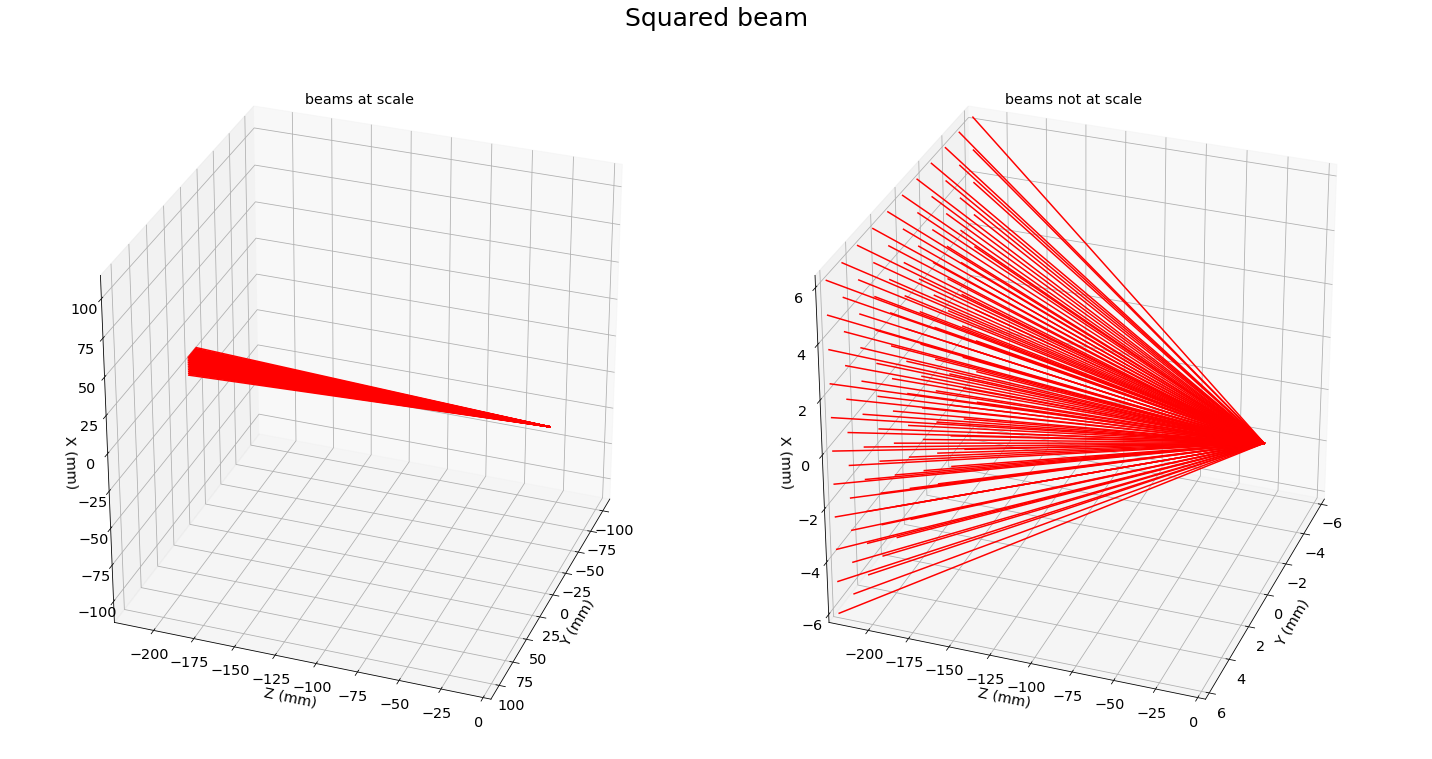

In [84]:
fig = plt.figure()
fig.set_size_inches(20,10)
#ax = fig.add_subplot(111, projection='3d', aspect='equal')
ax = fig.add_subplot(121, projection='3d')
ax.view_init(azim=20)


for i in np.arange(N):
    xs=(Y0[i],Y1[i])
    ys=(Z0[i],Z1[i])
    zs=(X0[i],X1[i])
    line = plt3d.art3d.Line3D(xs, ys, zs,color="red")
    ax.add_line(line)
    
ax.set_xlim3d(all_Y.min(), all_Y.max())
ax.set_ylim3d(all_Z.min(), all_Z.max())
ax.set_zlim3d(all_X.min(), all_X.max())
ax.set_xlabel('Y (mm)')
ax.set_ylabel('Z (mm)')
ax.set_zlabel('X (mm)')
ax.set_title('beams at scale')

set_aspect_equal_3d(ax)   


ax = fig.add_subplot(122, projection='3d')
ax.view_init(azim=20)


for i in np.arange(N):
    xs=(Y0[i],Y1[i])
    ys=(Z0[i],Z1[i])
    zs=(X0[i],X1[i])
    line = plt3d.art3d.Line3D(xs, ys, zs,color="red")
    ax.add_line(line)
    
ax.set_xlim3d(all_Y.min(), all_Y.max())
ax.set_ylim3d(all_Z.min(), all_Z.max())
ax.set_zlim3d(all_X.min(), all_X.max())
ax.set_xlabel('Y (mm)')
ax.set_ylabel('Z (mm)')
ax.set_zlabel('X (mm)')
ax.set_title('beams not at scale')

#set_aspect_equal_3d(ax) 

plt.tight_layout()
plt.suptitle("Squared beam",Y=1.05,fontsize=25)

2020-08-28 17:19:32 MacBook-Pro-de-admin.local matplotlib.axes._base[51916] DEBUG not adjusting title pos because a title was already placed manually: 0.920000
2020-08-28 17:19:32 MacBook-Pro-de-admin.local matplotlib.axes._base[51916] DEBUG title position was updated manually, not adjusting
2020-08-28 17:19:32 MacBook-Pro-de-admin.local matplotlib.axes._base[51916] DEBUG not adjusting title pos because a title was already placed manually: 0.920000
2020-08-28 17:19:32 MacBook-Pro-de-admin.local matplotlib.axes._base[51916] DEBUG title position was updated manually, not adjusting


Text(0.5, 1.05, 'Squared beam (longitudinal view)')

2020-08-28 17:19:32 MacBook-Pro-de-admin.local matplotlib.axes._base[51916] DEBUG title position was updated manually, not adjusting
2020-08-28 17:19:32 MacBook-Pro-de-admin.local matplotlib.axes._base[51916] DEBUG title position was updated manually, not adjusting
2020-08-28 17:19:32 MacBook-Pro-de-admin.local matplotlib.axes._base[51916] DEBUG title position was updated manually, not adjusting
2020-08-28 17:19:32 MacBook-Pro-de-admin.local matplotlib.axes._base[51916] DEBUG title position was updated manually, not adjusting
2020-08-28 17:19:32 MacBook-Pro-de-admin.local matplotlib.axes._base[51916] DEBUG title position was updated manually, not adjusting
2020-08-28 17:19:32 MacBook-Pro-de-admin.local matplotlib.axes._base[51916] DEBUG title position was updated manually, not adjusting
2020-08-28 17:19:32 MacBook-Pro-de-admin.local matplotlib.axes._base[51916] DEBUG title position was updated manually, not adjusting
2020-08-28 17:19:32 MacBook-Pro-de-admin.local matplotlib.axes._base[

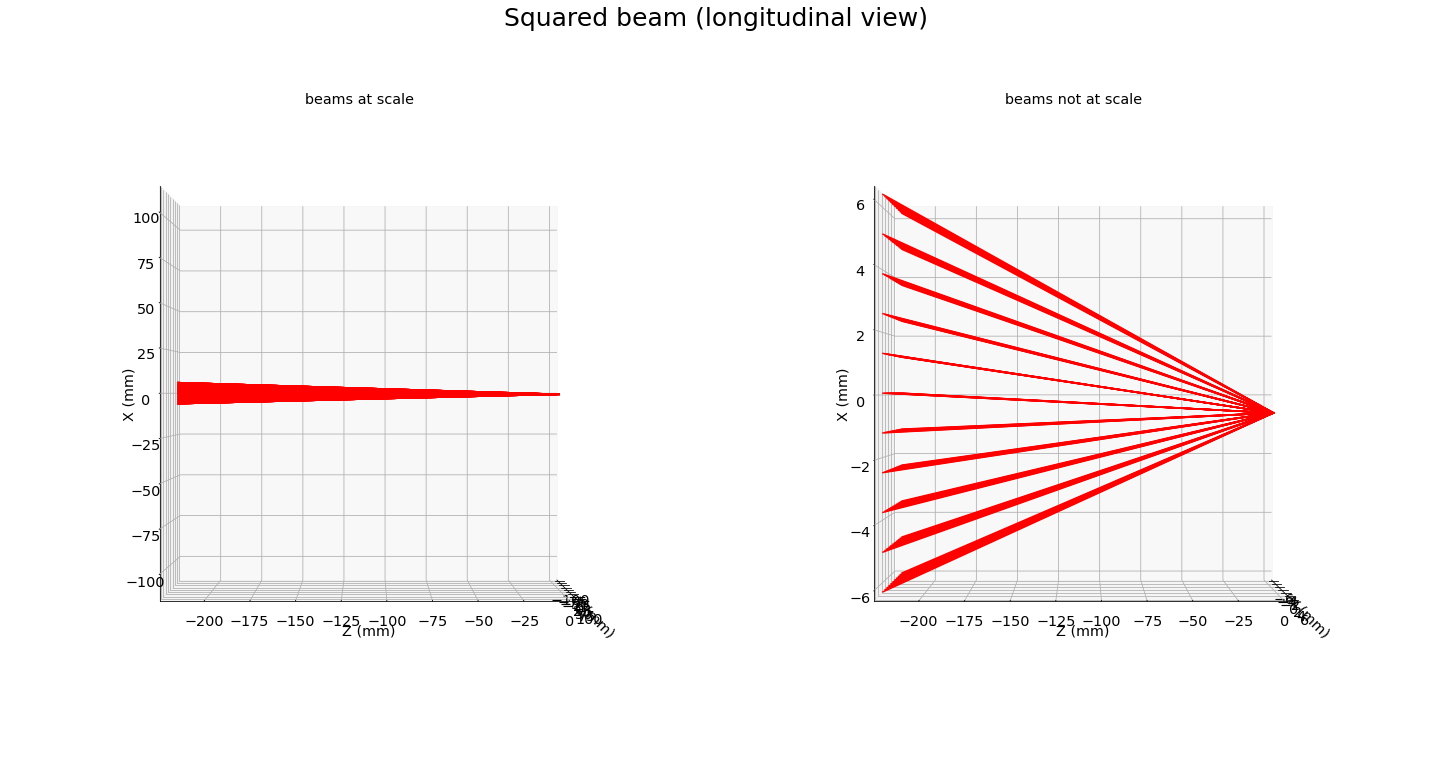

In [85]:
fig = plt.figure()
fig.set_size_inches(20,10)
#ax = fig.add_subplot(111, projection='3d', aspect='equal')
ax = fig.add_subplot(121, projection='3d')
ax.view_init(elev=0,azim=0)


for i in np.arange(N):
    xs=(Y0[i],Y1[i])
    ys=(Z0[i],Z1[i])
    zs=(X0[i],X1[i])
    line = plt3d.art3d.Line3D(xs, ys, zs,color="red")
    ax.add_line(line)
    
ax.set_xlim3d(all_Y.min(), all_Y.max())
ax.set_ylim3d(all_Z.min(), all_Z.max())
ax.set_zlim3d(all_X.min(), all_X.max())
ax.set_xlabel('Y (mm)')
ax.set_ylabel('Z (mm)')
ax.set_zlabel('X (mm)')
ax.set_title('beams at scale')

set_aspect_equal_3d(ax)   


ax = fig.add_subplot(122, projection='3d')
ax.view_init(elev=0,azim=0)


for i in np.arange(N):
    xs=(Y0[i],Y1[i])
    ys=(Z0[i],Z1[i])
    zs=(X0[i],X1[i])
    line = plt3d.art3d.Line3D(xs, ys, zs,color="red")
    ax.add_line(line)
    
ax.set_xlim3d(all_Y.min(), all_Y.max())
ax.set_ylim3d(all_Z.min(), all_Z.max())
ax.set_zlim3d(all_X.min(), all_X.max())
ax.set_xlabel('Y (mm)')
ax.set_ylabel('Z (mm)')
ax.set_zlabel('X (mm)')
ax.set_title('beams not at scale')

#set_aspect_equal_3d(ax) 

plt.tight_layout()
plt.suptitle("Squared beam (longitudinal view)",Y=1.05,fontsize=25)

# Write file with Python string Formater

In [86]:
f = open(Beam4_Rayfile_RAY, 'w')

In [87]:
def header(N,filename):
    """
    header(N,filename) : provide lines for the header of BeamFour Ray file.
    - input :
        - N : Number of beam rays
        - filename : Ray filename
    - output :
       the three header lines
    
    The width of the column must be kept fixed. The width = 12 is chosen.
    Note the : is the column separator used by BeamFour.
    
    """
    wd = ['X0', 'Y0', 'Z0','U0', 'V0', 'W0','@wave','X1', 'Y1', 'Z1','X2', 'Y2', 'Z2', 'X3', 'Y3', 'Z3','Xgoal','Ygoal','Xfinal','Yfinal','Zfinal','Notes']
    wd2 = "-----------:"
    
    
    line1 ="{:d} {}".format(N,filename)
    line1+= os.linesep
    
    line2 = ""
    Nwd=len(wd)
    
    for i in np.arange(Nwd):
        line2+=f"{wd[i]:^12}"
    line2+= os.linesep
    
    line3 = ""
    for i in np.arange(Nwd-1):
         line3+=f"{wd2:^12}"
    line3+="------------------"        
            
            
    line3+= os.linesep
        
    return line1, line2, line3

In [88]:
def GetLine(x0,y0,z0,u0,v0,w0,wa):
    """
    GetLine(x0,y0,z0,u0,v0,w0,wa) : provide the line format for each ray information.
    
    - input :
       - (x0,y0,z0) : coordinates of rays at beam entrance in mm unit
       - (u0,v0,w0) : cosinus director of rays at beam entrance
       - wa         : wavelength of the beam ray in mm
    
    - output :
       - the beam ray line.
    
    The width of the column must be kept fixed. The width = 12 is chosen.
    Note the : is the column separator used by BeamFour. The column width include the separator :
    
    """
   
    wd2 = "-----------:"
    wd0 = "           :"
    #line=f"{x0: {11.5}}:" + f"{y0: {11.5}}:" + f"{z0: {11.5}}:" + f"{u0: {11.5}}:" + f"{v0: {11.5}}:" + f"{w0: {11.5}}:" + f"{wa: {11.5}}:"
    
    line=f"{x0: {11.5}}:" + f"{y0: {11.5}}:" + f"{z0: {11}}:"+ f"{u0: {11.5}}:" + f"{v0: {11.5}}:" + f"{w0: {11.5}}:" + f"{wa: {11.6}}:"
    
    for i in np.arange(14):
        line+=wd0
        
    line+="             "
    line+= os.linesep
    
    return line

## Header

In [89]:
line1,line2,line3=header(NBEAM*NWL,Beam4_Rayfile_RAY)

In [90]:
f.write(line1)
f.write(line2)
f.write(line3)

271

## Beam rays

In [91]:
# loop on wavelengths
for iwl in np.arange(NWL):
    wl=WL[iwl]*1e-6   # wavelength in mm
    print(iwl," : wl=",wl*1e6)
    # loop on the NBEAM rays
    for idx in np.arange(len(df)):
        line4 =  GetLine(df["X0"][idx],df["Y0"][idx],df["Z0"][idx],df["U0"][idx],df["V0"][idx],df["W0"][idx],wl)
        f.write(line4)
        

0  : wl= 350.0
1  : wl= 375.0
2  : wl= 399.99999999999994
3  : wl= 425.0
4  : wl= 450.0
5  : wl= 475.0
6  : wl= 500.0
7  : wl= 525.0
8  : wl= 549.9999999999999
9  : wl= 575.0
10  : wl= 600.0
11  : wl= 625.0
12  : wl= 650.0
13  : wl= 674.9999999999999
14  : wl= 700.0
15  : wl= 725.0
16  : wl= 750.0
17  : wl= 775.0
18  : wl= 799.9999999999999
19  : wl= 825.0
20  : wl= 850.0
21  : wl= 874.9999999999999
22  : wl= 900.0
23  : wl= 924.9999999999999
24  : wl= 950.0
25  : wl= 975.0
26  : wl= 1000.0
27  : wl= 1024.9999999999998
28  : wl= 1050.0
29  : wl= 1075.0
30  : wl= 1099.9999999999998


In [92]:
f.close()